In [2]:
import os

# Select the backend before importing folps.py
os.environ["FOLPS_BACKEND"] = "numpy"  #'numpy' or 'jax'

from folps import *
from cosmo_class import *

✅ Using NumPy with CPU.


In [11]:
%%time
#linear power spectrum
classy  = run_class(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.1/93.14, 
                    As = 2e-9, ns = 0.965, z = 1., z_scale=[0.97],
                    N_ur = 2.0328,
                    khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')
kwargs = {'z': 1., 'h': 0.6711, 'Omega_m': classy['cosmo'].Omega0_m(),
          'fnu':classy['cosmo'].scale_independent_growth_factor_f(1.)}

CPU times: user 20.9 s, sys: 1.43 s, total: 22.3 s
Wall time: 365 ms


In [12]:
matrix = MatrixCalculator(A_full=False)
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_Afull_False_remove-DeltaP_False.npy


In [13]:
%%time
nonlinear = NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='eds',
                                             **kwargs)
nonlinear2 = NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='fk',
                                             **kwargs)

CPU times: user 355 µs, sys: 0 ns, total: 355 µs
Wall time: 346 µs


In [14]:
%%time
table, table_now = nonlinear.calculate_loop_table(k=classy['k'], pklin=classy['pk'],cosmo=classy['cosmo'], **kwargs)
table2, table_now2 = nonlinear2.calculate_loop_table(k=classy['k'], pklin=classy['pk'],cosmo=classy['cosmo'], **kwargs)

CPU times: user 9.35 s, sys: 549 ms, total: 9.9 s
Wall time: 115 ms


In [15]:
# Bias parameters
b1 = 1.645
b2 = -0.46
bs2 = -4./7*(b1 - 1)
b3nl = 32./315*(b1 - 1)
# EFT parameters
alpha0 = 3                 #units: [Mpc/h]^2
alpha2 = -28.9             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
PshotP = 1. / 0.0002118763
alphashot0 = 0.08
alphashot2 = -8.1          #units: [Mpc/h]^2
X_Fog_pk = 0
pars = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP, X_Fog_pk]
qpar, qper = 1., 1.


k = np.logspace(np.log10(0.01), np.log10(0.3), num=100) # array of  output k in [h/Mpc]

In [16]:
%%time
multipoles = RSDMultipolesPowerSpectrumCalculator()#model='EFT'
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars,
                                       table=table, table_now=table_now,
                                       bias_scheme='folps', damping=None)

P02, P22, P42  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars,
                                       table=table2, table_now=table_now2,
                                       bias_scheme='folps', damping=None)                                    

CPU times: user 6.28 ms, sys: 0 ns, total: 6.28 ms
Wall time: 5.35 ms


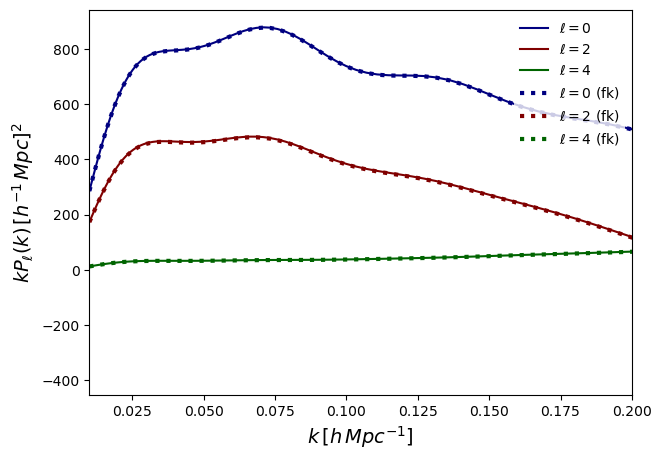

In [17]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k, k * P0, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, k * P2, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, k * P4, color = 'darkgreen', ls='-', label=r'$\ell = 4$')

axs.plot(k, k * P02, color = 'navy', ls=':', lw=3,label=r'$\ell = 0$ (fk)')
axs.plot(k, k * P22, color = 'maroon', ls=':', lw=3,label=r'$\ell = 2$ (fk)')
axs.plot(k, k * P42, color = 'darkgreen', ls=':', lw=3, label=r'$\ell = 4$ (fk)')


axs.set_xlim([k[0], 0.2])
#axs.set_ylim([-200.0, 1800])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

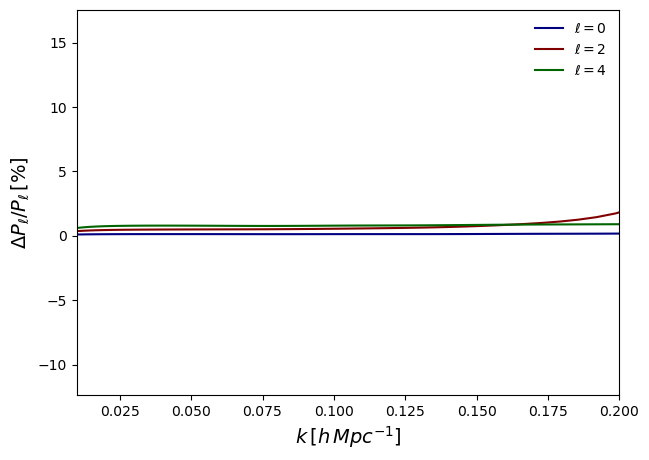

In [18]:
# Make a plot of relative difference b/w eds and fk kernels
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$\Delta P_{\ell} / P_{\ell} \, [\%]$', fontsize =  14)
axs.plot(k, (P0 - P02) / P02 * 100, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, (P2 - P22) / P22 * 100, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, (P4 - P42) / P42 * 100, color = 'darkgreen', ls='-', label=r'$\ell = 4$')
axs.set_xlim([k[0], 0.2])
leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);
plt.show()

In [31]:
P0

array([52897.06504797, 53603.33028676, 54280.39311216, 54925.61356453,
       55535.8776154 , 56107.8943982 , 56638.45335919, 57124.53934588,
       57563.40951371, 57952.18116055, 58287.60246871, 58565.76418711,
       58783.21160368, 58937.19983534, 59024.81835579, 59043.33916564,
       58990.21458429, 58862.25872996, 58657.00366029, 58373.24899608,
       58009.44984079, 57564.20289185, 57036.63162384, 56426.65030959,
       55735.2289584 , 54964.46684149, 54116.49584265, 53193.61053247,
       52198.41089454, 51134.81881563, 50008.85610772, 48829.16467875,
       47603.99673226, 46341.36635036, 45049.28513194, 43735.00120651,
       42406.78483612, 41076.72533526, 39756.95850944, 38458.95270485,
       37193.01141337, 35967.39818886, 34788.6744164 , 33662.90747905,
       32595.32331967, 31590.33409479, 30651.85853453, 29779.48266735,
       28968.2284128 , 28212.85694239, 27505.64578513, 26835.61702794,
       26189.75060377, 25553.36275811, 24910.65624806, 24246.29301735,
      

In [32]:
P0

array([52897.06504797, 53603.33028676, 54280.39311216, 54925.61356453,
       55535.8776154 , 56107.8943982 , 56638.45335919, 57124.53934588,
       57563.40951371, 57952.18116055, 58287.60246871, 58565.76418711,
       58783.21160368, 58937.19983534, 59024.81835579, 59043.33916564,
       58990.21458429, 58862.25872996, 58657.00366029, 58373.24899608,
       58009.44984079, 57564.20289185, 57036.63162384, 56426.65030959,
       55735.2289584 , 54964.46684149, 54116.49584265, 53193.61053247,
       52198.41089454, 51134.81881563, 50008.85610772, 48829.16467875,
       47603.99673226, 46341.36635036, 45049.28513194, 43735.00120651,
       42406.78483612, 41076.72533526, 39756.95850944, 38458.95270485,
       37193.01141337, 35967.39818886, 34788.6744164 , 33662.90747905,
       32595.32331967, 31590.33409479, 30651.85853453, 29779.48266735,
       28968.2284128 , 28212.85694239, 27505.64578513, 26835.61702794,
       26189.75060377, 25553.36275811, 24910.65624806, 24246.29301735,
      

In [33]:
#pars for Bispectrum
z_pk=0.3;


b1v = 1;
b2v = 0.0;
bsv = 0;
c1v = 0; 
c2v = 0
X_FoG_b = 0

Omv=classy['cosmo'].Omega0_m();
hv=classy['cosmo'].h(); 
f=classy['cosmo'].scale_independent_growth_factor_f(z_pk)

qparv = 1; qperpv = 1;
Bshotv=0.0
Pshotv=0.0

f0 = nonlinear.f0

bisp_nuis_params = [b1v, b2v, bsv, c1v, c2v, Bshotv, Pshotv, X_Fog_pk]
#bisp_cosmo_params = [classy['cosmo'].Omega0_m(),classy['cosmo'].h]

In [34]:
ks = np.logspace(np.log10(0.0001), np.log10(0.4), 30)
k1k2T = np.vstack([ks,ks]).T

In [35]:
bispectrum = BispectrumCalculator(basis='sugiyama')

In [36]:
pklir = get_linear_ir_ini(table[0], table[1], table_now[1], h=classy['cosmo'].h)

In [37]:
%%time
B000, B202 = bispectrum.Bisp_Sugiyama(f=f0, f0=f0, bpars=bisp_nuis_params,
                                      pk_input=pklir, z_pk=z_pk,
                                      k1k2pairs=k1k2T, qpar=1, qperp=1, precision=[4, 5, 5], damping='lor')

CPU times: user 10.5 ms, sys: 7.82 ms, total: 18.3 ms
Wall time: 17.6 ms


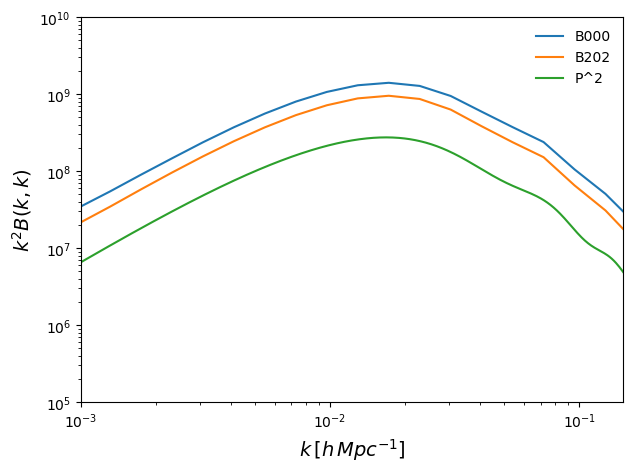

In [38]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) $', fontsize =  14)



axs.loglog(k1k2T.T[0],B000, ls='-', label='B000')
axs.loglog(k1k2T.T[0],B202, ls='-', label='B202')
axs.loglog(nonlinear.inputpkT[0],nonlinear.inputpkT[1]*nonlinear.inputpkT[1], ls='-', label='P^2')



axs.set_xlim([0.001,0.15])
axs.set_ylim([1e5, 1e10])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()